<a href="https://colab.research.google.com/github/NancyBiyahut/intrusion-detection-autoencoder/blob/main/LSTMautoencoder_cic_2017_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from mpl_toolkits import mplot3d
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from scipy.spatial.distance import euclidean
import random
import seaborn as sns
from itertools import combinations, product
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score

In [4]:
df1= pd.read_csv('Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
df2 = pd.read_csv('Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
df3 = pd.read_csv('Friday-WorkingHours-Morning.pcap_ISCX.csv')
df4 = pd.read_csv('Monday-WorkingHours.pcap_ISCX.csv')
df5 = pd.read_csv('Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
df6 = pd.read_csv('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
df7 = pd.read_csv('Tuesday-WorkingHours.pcap_ISCX.csv')
df8 = pd.read_csv('Wednesday-workingHours.pcap_ISCX.csv')
df = pd.concat([df1, df2, df3 , df4,df5,df6,df7,df8], ignore_index=True)
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [5]:
np.random.seed(42)
# Sample a small subset of data for testing
df_data = df.sample(frac=0.3, random_state=42)
print(df_data.shape)
# Assuming obj is the object whose datatype you want to check
obj_type = type(df_data)
print(obj_type)


(686523, 79)
<class 'pandas.core.frame.DataFrame'>


In [6]:
# 1.2.1 - Data preprocessing

# Find and handle null values
null_counts = df_data.isnull().sum()
# Print the number of null values
print(f"{null_counts.sum()} null entries have been found in the dataset\n")
# Drop null values
df_data.dropna(inplace=True)          # or df_data = df_data.dropna()

# Find and handle duplicates
duplicate_count = df_data.duplicated().sum()
# Print the numer of duplicate entries
print(f"{duplicate_count} duplicate entries have been found in the dataset\n")
# Remove duplicates
df_data.drop_duplicates(inplace=True)  # or df_data = df_data.drop_duplicates()
# Display relative message
print(f"All duplicates have been removed\n")

# Reset the indexes
df_data.reset_index(drop=True, inplace=True)

# Inspect the dataset for categorical columns
print("Categorical column:",df_data.select_dtypes(include=['object']).columns.tolist(),'\n')

# Print the first 5 lines
df_data.head()

470 null entries have been found in the dataset

50193 duplicate entries have been found in the dataset

All duplicates have been removed

Categorical column: [' Label'] 



,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,53,30849,2,2,86,198,43,43,43.000000,0.000000,...,32.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,BENIGN
1,443,118036149,19,24,2656,9443,1072,0,139.789474,297.243555,...,20.0,489225.5,568844.0709,891459.0,86992.0,58500000.0,302077.4311,58700000.0,58300000.0,BENIGN
2,6059,95,2,2,4,12,2,2,2.000000,0.000000,...,24.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,BENIGN
3,53,71301,2,2,62,246,31,31,31.000000,0.000000,...,20.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,BENIGN
4,80,5023992,3,1,12,0,6,0,4.000000,3.464102,...,20.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,BENIGN


In [7]:
# 1.2.2 - Inspection of Target Feature
# Drop rows containing infinite or NaN values
df_data= df_data.replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN
df_data = df_data.dropna()
print('Shape of Dataframe: ',df_data.shape,'\n')
print('Inspection of Target Feature - y:\n')
# Target feature counts
print(df_data[' Label'].value_counts())

Shape of Dataframe:  (635599, 79) 

Inspection of Target Feature - y:

 Label
BENIGN                        499402
DoS Hulk                       52432
DDoS                           38368
PortScan                       37721
FTP-Patator                     1894
DoS Slowhttptest                1634
DoS slowloris                   1620
SSH-Patator                      939
Bot                              579
Web Attack � Brute Force         474
DoS GoldenEye                    327
Web Attack � XSS                 195
Infiltration                       8
Web Attack � Sql Injection         6
Name: count, dtype: int64


In [8]:
# 1.2.3 - Set up binary configuration

# Extract features as X
X = df_data.copy()
X = X.drop(' Label', axis=1)

# Extract target as y
y = df_data[' Label'].copy()

# Binarize labels
y = y.map({'BENIGN': 0}).fillna(1)

<ipython-input-9-79026fcf8b61>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='Set1')


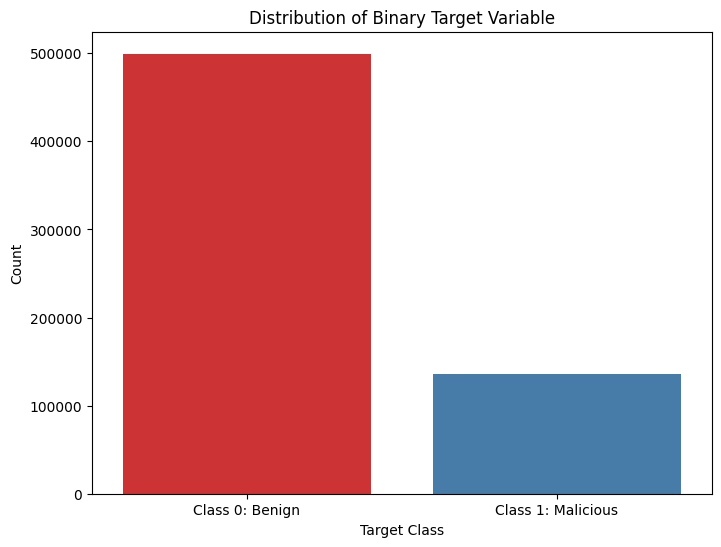

Class 0 ratio: 78.57%
Class 1 ratio: 21.43%


In [9]:
# 1.2.4 - Visualize dataset imbalance

""" As evident from the output of cell 1.2.2, the dataset exhibits a significant class imbalance."""

# Plotting the distribution of the binary target variable y
plt.figure(figsize=(8, 6))
sns.countplot(x=y, palette='Set1')
plt.title('Distribution of Binary Target Variable')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Class 0: Benign', 'Class 1: Malicious'])
plt.show()

# Calculate the count and ratio of each class
class_counts = y.value_counts()
class_ratios = class_counts / len(y)

# Print the ratio of each class
print(f"Class 0 ratio: {class_ratios[0]*100:.2f}%")
print(f"Class 1 ratio: {class_ratios[1]*100:.2f}%")

In [10]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


# Instantiate the Gradient Boosting Regressor
regressor = RandomForestClassifier()

# Train the regressor
regressor.fit(X, y)

# Extract feature importances
feature_importances = regressor.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)


                    Feature  Importance
39        Max Packet Length    0.070165
54     Avg Bwd Segment Size    0.069807
42   Packet Length Variance    0.065763
41        Packet Length Std    0.063166
52      Average Packet Size    0.053638
..                      ...         ...
59       Bwd Avg Bytes/Bulk    0.000000
58        Fwd Avg Bulk Rate    0.000000
31            Bwd PSH Flags    0.000000
56       Fwd Avg Bytes/Bulk    0.000000
57     Fwd Avg Packets/Bulk    0.000000

[78 rows x 2 columns]


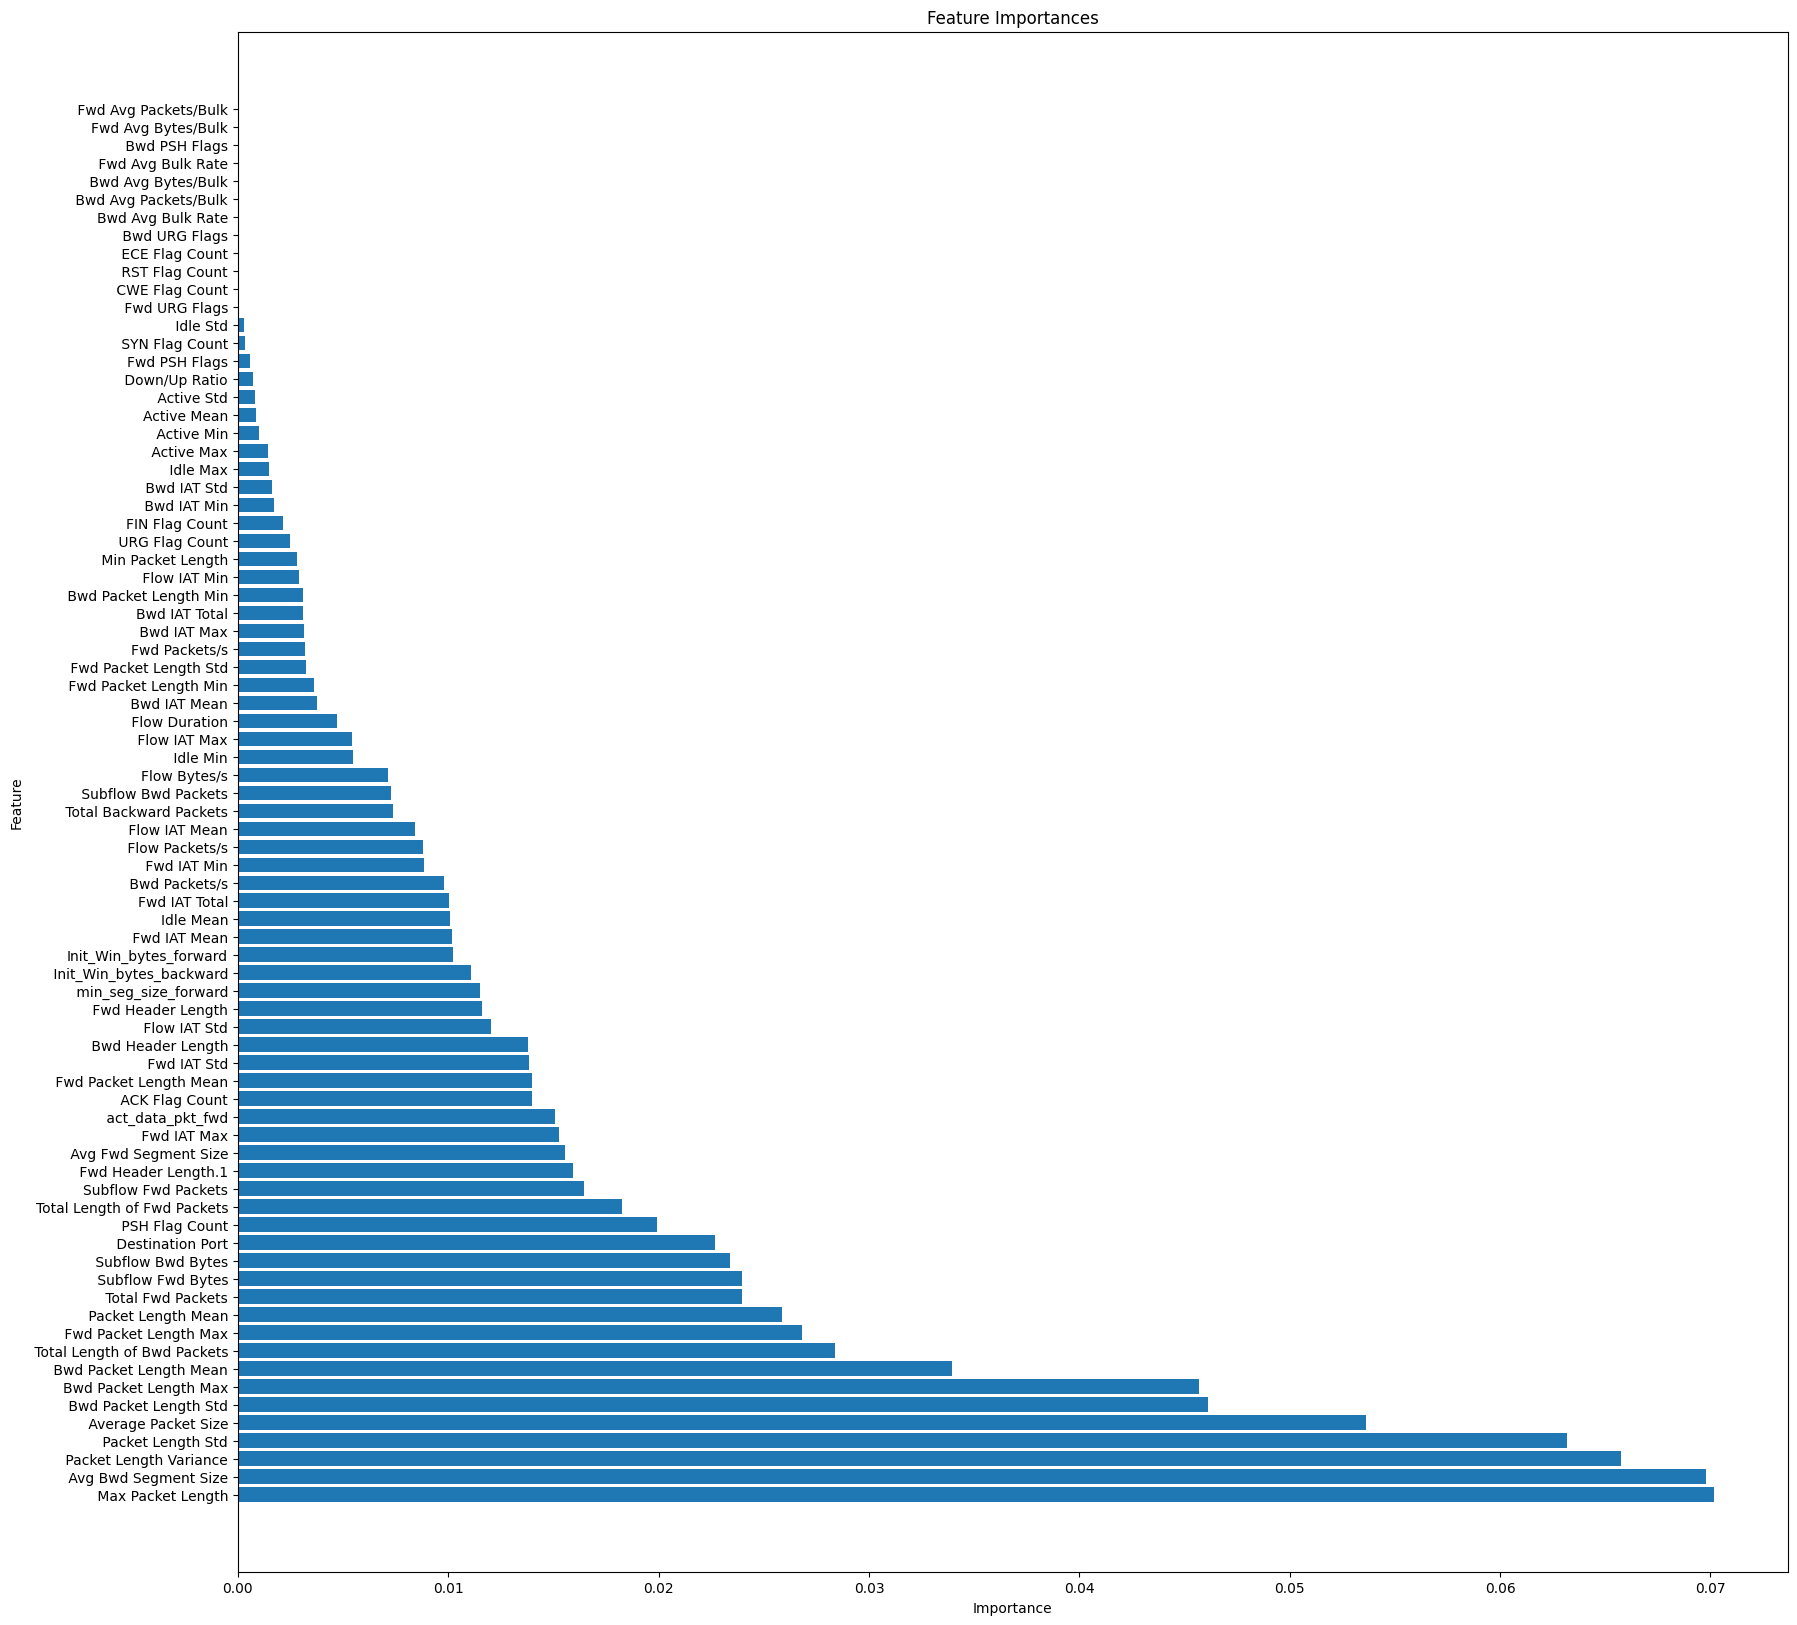

In [11]:
# Plot the feature importances
plt.figure(figsize=(20, 20))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [12]:
# Set a threshold for feature importance (e.g., keep features with importance >= 0.05)
threshold = 0.01

# Filter the DataFrame to keep only features with importance >= threshold
selected_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature']

# Drop the less important features from the original DataFrame df
df = df_data[selected_features]
df['Label'] = df_data[' Label']
print(df.shape)
df.head()

(635599, 35)


<ipython-input-12-a57950b113d7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Label'] = df_data[' Label']


,Max Packet Length,Avg Bwd Segment Size,Packet Length Variance,Packet Length Std,Average Packet Size,Bwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,Total Length of Bwd Packets,Fwd Packet Length Max,...,Bwd Header Length,Flow IAT Std,Fwd Header Length,min_seg_size_forward,Init_Win_bytes_backward,Init_Win_bytes_forward,Fwd IAT Mean,Idle Mean,Fwd IAT Total,Label
0,99.0,99.000000,940.800,30.672463,81.750000,0.000000,99,99.000000,198,43,...,64.0,1.780548e+04,64.0,32.0,-1.0,-1.0,3.000,0.0,3.0,BENIGN
1,1430.0,393.458333,231355.139,480.993907,281.372093,574.764449,1430,393.458333,9443,1072,...,492.0,1.260000e+07,392.0,20.0,395.0,8192.0,6557563.833,58500000.0,118000000.0,BENIGN
2,6.0,6.000000,4.800,2.190890,4.500000,0.000000,6,6.000000,12,2,...,40.0,2.655811e+01,48.0,24.0,0.0,1024.0,48.000,0.0,48.0,BENIGN
3,123.0,123.000000,2539.200,50.390475,84.750000,0.000000,123,123.000000,246,31,...,64.0,4.115959e+04,40.0,20.0,-1.0,-1.0,3.000,0.0,3.0,BENIGN
4,6.0,0.000000,10.800,3.286335,3.000000,0.000000,0,0.000000,0,6,...,32.0,2.880522e+06,72.0,20.0,65535.0,8192.0,2511996.000,0.0,5023992.0,BENIGN


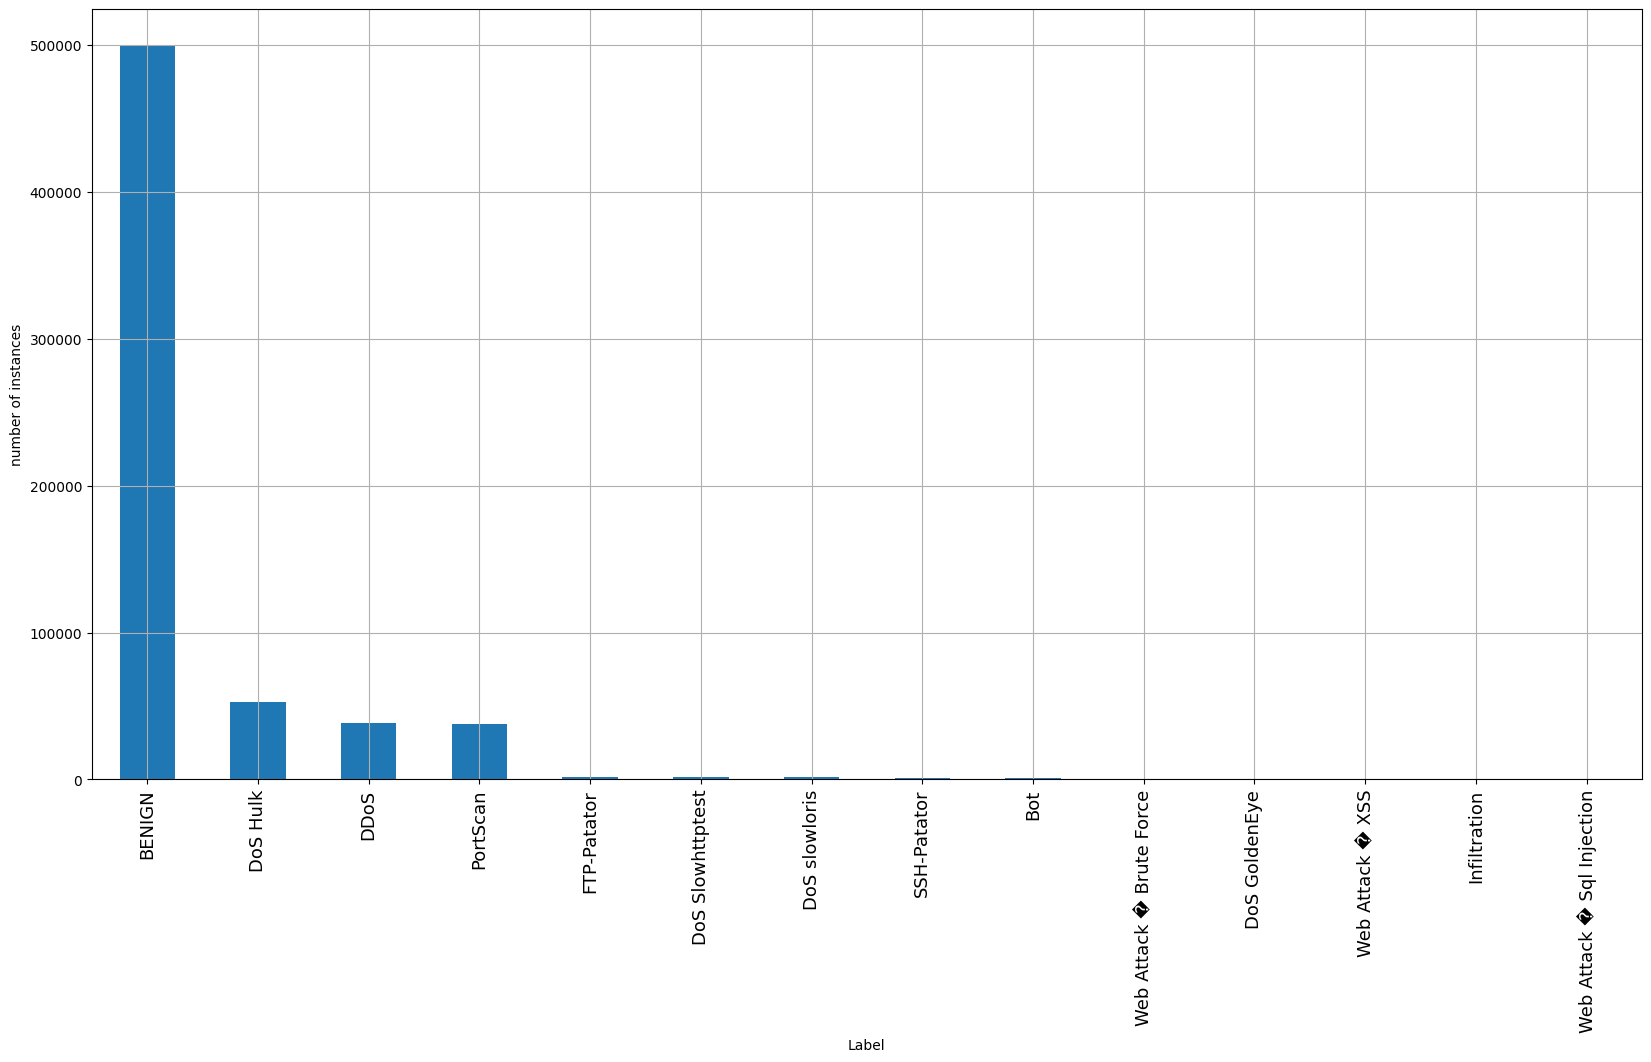

In [13]:
pd.value_counts(df['Label']).plot(kind='bar', figsize=(20, 10))
plt.ylabel('number of instances')
plt.xticks(fontsize=13)
plt.grid()
plt.show()

In [14]:
normal_instances = df[df['Label']=='BENIGN'].shape[0]
anomalous_instances = df[df['Label']!='BENIGN'].shape[0]
print(normal_instances)
print(anomalous_instances)
print('percentage of anomalies = {}'.format(100*anomalous_instances/normal_instances))

499402
136197
percentage of anomalies = 27.272017332729945


In [15]:
df.head()

,Max Packet Length,Avg Bwd Segment Size,Packet Length Variance,Packet Length Std,Average Packet Size,Bwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,Total Length of Bwd Packets,Fwd Packet Length Max,...,Bwd Header Length,Flow IAT Std,Fwd Header Length,min_seg_size_forward,Init_Win_bytes_backward,Init_Win_bytes_forward,Fwd IAT Mean,Idle Mean,Fwd IAT Total,Label
0,99.0,99.000000,940.800,30.672463,81.750000,0.000000,99,99.000000,198,43,...,64.0,1.780548e+04,64.0,32.0,-1.0,-1.0,3.000,0.0,3.0,BENIGN
1,1430.0,393.458333,231355.139,480.993907,281.372093,574.764449,1430,393.458333,9443,1072,...,492.0,1.260000e+07,392.0,20.0,395.0,8192.0,6557563.833,58500000.0,118000000.0,BENIGN
2,6.0,6.000000,4.800,2.190890,4.500000,0.000000,6,6.000000,12,2,...,40.0,2.655811e+01,48.0,24.0,0.0,1024.0,48.000,0.0,48.0,BENIGN
3,123.0,123.000000,2539.200,50.390475,84.750000,0.000000,123,123.000000,246,31,...,64.0,4.115959e+04,40.0,20.0,-1.0,-1.0,3.000,0.0,3.0,BENIGN
4,6.0,0.000000,10.800,3.286335,3.000000,0.000000,0,0.000000,0,6,...,32.0,2.880522e+06,72.0,20.0,65535.0,8192.0,2511996.000,0.0,5023992.0,BENIGN


In [16]:
obj_type = type(df)
print(obj_type)

<class 'pandas.core.frame.DataFrame'>


In [17]:
df_http_normal = df[df['Label']=='BENIGN']
df_http_normal.drop(columns=['Label'], inplace=True)
df_http_normal.describe()

<ipython-input-17-24d37b209ab5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_http_normal.drop(columns=['Label'], inplace=True)


,Max Packet Length,Avg Bwd Segment Size,Packet Length Variance,Packet Length Std,Average Packet Size,Bwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,Total Length of Bwd Packets,Fwd Packet Length Max,...,Fwd IAT Std,Bwd Header Length,Flow IAT Std,Fwd Header Length,min_seg_size_forward,Init_Win_bytes_backward,Init_Win_bytes_forward,Fwd IAT Mean,Idle Mean,Fwd IAT Total
count,499402.000000,499402.000000,4.994020e+05,499402.000000,499402.000000,499402.000000,499402.000000,499402.000000,4.994020e+05,499402.000000,...,4.994020e+05,4.994020e+05,4.994020e+05,4.994020e+05,4.994020e+05,499402.000000,499402.000000,4.994020e+05,4.994020e+05,4.994020e+05
mean,587.572349,179.919031,1.446951e+05,174.817017,138.968315,147.155057,463.183844,179.919031,2.741993e+04,278.710592,...,1.505675e+06,-4.434131e+03,1.890767e+06,-3.135262e+04,-5.685411e+03,2482.686675,8092.156952,2.272243e+06,4.475964e+06,1.309389e+07
std,1184.214648,307.116556,6.615127e+05,337.839973,213.292742,295.368667,881.121261,307.116556,3.104468e+06,892.673619,...,5.111293e+06,2.165260e+06,6.354273e+06,1.199085e+07,1.707017e+06,9398.761358,16018.342412,1.006484e+07,1.459059e+07,3.250549e+07
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000e+00,-1.073741e+09,0.000000e+00,-6.442448e+09,-5.368707e+08,-1.000000,-1.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,23.000000,6.000000,4.800000e+00,2.190890,9.000000,0.000000,6.000000,6.000000,6.000000e+00,6.000000,...,0.000000e+00,2.000000e+01,0.000000e+00,4.000000e+01,2.000000e+01,-1.000000,-1.000000,1.000000e+00,0.000000e+00,1.000000e+00
50%,100.000000,82.000000,9.499556e+02,30.821349,79.500000,0.000000,94.000000,82.000000,1.360000e+02,43.000000,...,0.000000e+00,4.000000e+01,1.827320e+02,6.400000e+01,2.000000e+01,-1.000000,229.000000,4.800000e+01,0.000000e+00,4.800000e+01
75%,517.000000,168.400000,2.409502e+04,155.225701,141.500000,66.560123,237.000000,168.400000,4.200000e+02,199.000000,...,5.873968e+04,1.040000e+02,6.890910e+05,1.320000e+02,3.200000e+01,243.000000,8192.000000,1.649443e+05,0.000000e+00,1.092674e+06
max,24820.000000,3691.646341,2.240000e+07,4731.522394,3558.000000,3433.501973,13140.000000,3691.646341,6.270000e+08,24820.000000,...,8.441797e+07,5.634820e+06,8.480026e+07,4.340524e+06,6.000000e+01,65535.000000,65535.000000,1.200000e+08,1.200000e+08,1.200000e+08


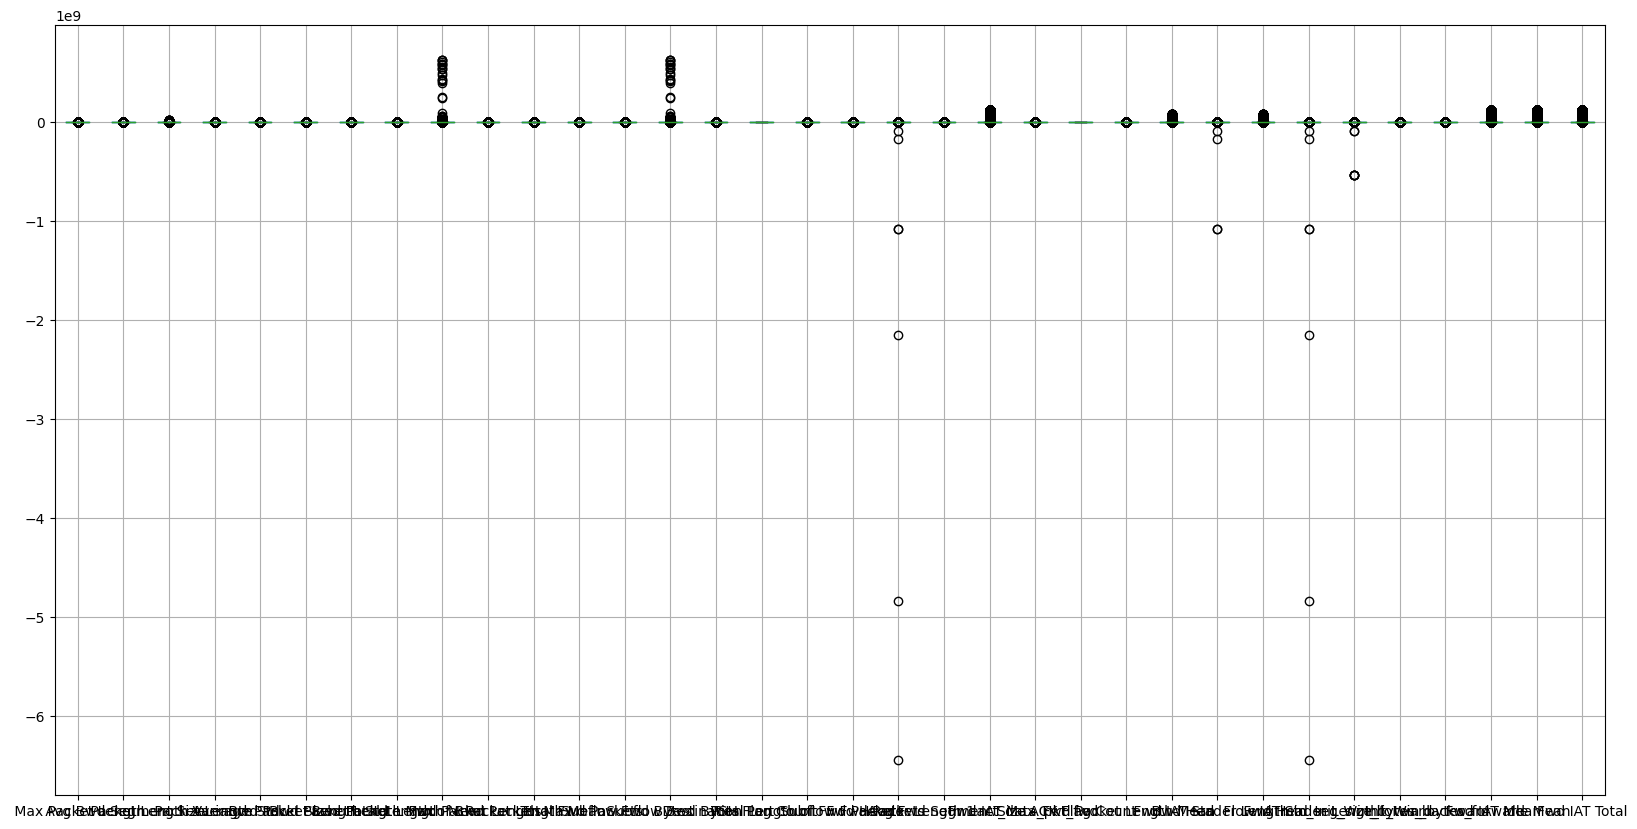

In [18]:
df_http_normal.boxplot(figsize=(20, 10))
plt.show()

In [19]:
# scaling the data using standard scaler
scaler = StandardScaler()
df_http_normal = pd.DataFrame(scaler.fit_transform(df_http_normal), columns=df_http_normal.columns)

In [20]:
# reducing the dimensionality of the data using PCA and covering 80% of the variance in the original data
pca = PCA(n_components=0.80)
pca.fit(df_http_normal)

PCA(n_components=0.8)

In [21]:
pca_cols = ['PCA_'+ str(i) for i in range(pca.n_components_)]
df_pca = pd.DataFrame(pca.transform(df_http_normal), columns=pca_cols)

In [22]:
df_pca.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
0,-1.333394,0.249426,-0.152867,-0.202082,-0.000905,1.037738
1,5.045163,-1.327498,2.683280,4.024231,-0.022471,-0.336620
2,-1.415710,0.208026,-0.357875,0.090001,-0.003329,0.699255
3,-1.283964,0.233914,-0.233021,-0.158241,-0.000766,1.009969
4,-1.122609,0.102824,0.010490,0.491580,-0.013103,-2.120458


In [23]:
def get_windows(df, window_size=20, stride=10):
  windows_arr = []
  for i in tqdm.tqdm(range(0, len(df)-window_size+1, stride)):
    windows_arr.append(df.iloc[i:i+window_size, :].to_numpy())
  return np.array(windows_arr)

In [24]:
window_size, stride = 10, 10
windows_arr = get_windows(df_pca, window_size, stride)

100%|██████████| 49940/49940 [00:04<00:00, 12018.10it/s]


In [25]:
# shuffling windows for training purpose
indices = np.arange(windows_arr.shape[0])
np.random.shuffle(indices)
windows_shuffled = windows_arr[indices]

LSTM Autoencoder

In [30]:
K.clear_session()
# encoder model with stacked LSTM
encoder = Sequential([LSTM(80, return_sequences=True, activation='selu',input_shape=(window_size, 6), dropout=0.2), LSTM(50, activation='selu', return_sequences=True),
                      LSTM(20, activation='selu')], name='encoder')
# decoder model with output dimension same as input dimension
decoder = Sequential([RepeatVector(window_size), LSTM(50, activation='selu', return_sequences=True), LSTM(80, activation='selu',return_sequences=True),
                      TimeDistributed(Dense(6, activation='linear'))], name='decoder')
# creating sequential autoencoder using encoder, decoder as layers
autoencoder = Sequential([encoder, decoder], name='autoencoder')
autoencoder.compile(optimizer='adam', loss = tf.keras.losses.Huber(100.))
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 20)                59720     
                                                                 
 decoder (Sequential)        (None, 10, 6)             56606     
                                                                 
Total params: 116326 (454.40 KB)
Trainable params: 116326 (454.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
encoder.summary(), decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 80)            27840     
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            26200     
                                                                 
 lstm_2 (LSTM)               (None, 20)                5680      
                                                                 
Total params: 59720 (233.28 KB)
Trainable params: 59720 (233.28 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 repeat_vector (RepeatVecto  (None, 10, 20)            0         
 r)                                                              
    

(None, None)

In [32]:
check_point = tf.keras.callbacks.ModelCheckpoint('autoencoder.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
train_hist = autoencoder.fit(windows_shuffled, windows_shuffled[:, :, ::-1], batch_size=64, validation_split=0.2, epochs=10, callbacks=[check_point])

Epoch 1/10
624/625 [============================>.] - ETA: 0s - loss: 1.4395
Epoch 1: val_loss improved from inf to 0.82560, saving model to autoencoder.h5
625/625 [==============================] - 48s 66ms/step - loss: 1.4392 - val_loss: 0.8256
Epoch 2/10
  1/625 [..............................] - ETA: 34s - loss: 0.7014

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - ETA: 0s - loss: 1.0925
Epoch 2: val_loss improved from 0.82560 to 0.69019, saving model to autoencoder.h5
625/625 [==============================] - 40s 64ms/step - loss: 1.0925 - val_loss: 0.6902
Epoch 3/10
625/625 [==============================] - ETA: 0s - loss: 0.9777
Epoch 3: val_loss improved from 0.69019 to 0.58068, saving model to autoencoder.h5
625/625 [==============================] - 49s 79ms/step - loss: 0.9777 - val_loss: 0.5807
Epoch 4/10
625/625 [==============================] - ETA: 0s - loss: 0.9850
Epoch 4: val_loss improved from 0.58068 to 0.54349, saving model to autoencoder.h5
625/625 [==============================] - 41s 65ms/step - loss: 0.9850 - val_loss: 0.5435
Epoch 5/10
625/625 [==============================] - ETA: 0s - loss: 0.9175
Epoch 5: val_loss did not improve from 0.54349
625/625 [==============================] - 41s 66ms/step - loss: 0.9175 - val_loss: 0.5644
Epoch 6/10
624/625 [=======================

In [33]:
# restoring the best model
autoencoder_loaded = tf.keras.models.load_model('autoencoder.h5')

Testing

In [34]:
test_df_http =df.sample(frac=0.4, random_state=42)
test_df_http.head()

,Max Packet Length,Avg Bwd Segment Size,Packet Length Variance,Packet Length Std,Average Packet Size,Bwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,Total Length of Bwd Packets,Fwd Packet Length Max,...,Bwd Header Length,Flow IAT Std,Fwd Header Length,min_seg_size_forward,Init_Win_bytes_backward,Init_Win_bytes_forward,Fwd IAT Mean,Idle Mean,Fwd IAT Total,Label
319915,274.0,0.0,2.394133e+04,154.729872,277.000000,0.000000,0,0.0,0,274,...,0.0,0.000000e+00,40.0,20.0,-1.0,60.0,4.000,0.000,4.0,BENIGN
134879,4614.0,1295.4,1.100656e+06,1049.121572,689.701149,1174.182276,4614,1295.4,58293,390,...,1056.0,3.352050e+06,852.0,20.0,1047.0,8192.0,2831778.049,9999759.545,116000000.0,BENIGN
635220,211.0,211.0,6.934444e+03,83.273312,138.625000,0.000000,211,211.0,844,53,...,128.0,2.891172e+04,104.0,20.0,-1.0,-1.0,28648.000,0.000,85944.0,BENIGN
364186,6.0,0.0,1.080000e+01,3.286335,4.500000,0.000000,0,0.0,0,6,...,64.0,8.264342e+03,40.0,20.0,235.0,0.0,1105.000,0.000,1105.0,DoS Hulk
587594,66.0,66.0,1.323000e+02,11.502174,66.750000,0.000000,66,66.0,132,45,...,80.0,6.780055e+04,64.0,32.0,-1.0,-1.0,1.000,0.000,1.0,BENIGN


In [35]:
# binary indicator to represent anomalies
status = pd.Series([0 if i=='BENIGN' else 1 for i in test_df_http['Label']])
test_labels = [1 if np.sum(status[i:i+window_size])>0 else 0 for i in range(0, len(status)-window_size+1, stride)]

In [36]:
test_df_http_pca = pd.DataFrame(pca.transform(test_df_http.drop(columns = ['Label'])), columns=pca_cols)
test_df_http_pca.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
0,4.132462e+03,2.833675e+02,1.117071e+04,-1.746643e+04,-145.598115,-2.863155e+04
1,2.491304e+07,-8.007198e+06,2.421381e+07,3.933596e+07,-193574.969245,-1.037800e+07
2,4.415953e+04,-1.480300e+04,6.679350e+04,6.990419e+04,-594.503102,-1.206153e+04
3,1.379218e+03,-5.863431e+02,3.346897e+03,3.636470e+03,-102.873729,-1.085239e+02
4,7.811030e+03,-3.384740e+03,2.092093e+04,2.208385e+04,-295.696899,8.691024e+02


In [37]:
test_windows = get_windows(test_df_http_pca, window_size=10, stride=10)

100%|██████████| 25424/25424 [00:01<00:00, 19383.35it/s]


In [38]:
test_windows_pred = autoencoder_loaded.predict(test_windows)

795/795 [==============================] - 14s 15ms/step


In [39]:
# calculating reconstruction error for each sample
# implemented in tensorflow for faster execution when gpu is available

def get_recon_erros(true_windows, pred_windows):
  recon_errors = []

  def cond(y_true, y_pred, i, iters):
    return tf.less(i, iters)

  def body(y_true, y_pred, i, iters):
    tensor_for_error = tf.math.subtract(tf.slice(y_true, [i, 0, 0], [1, -1, -1]), tf.slice(y_pred, [i, 0, 0], [1, -1, -1]))
    tensor_for_error = tf.reshape(tensor_for_error, [window_size, pca.n_components_])
    recon_error = tf.math.reduce_mean(tf.norm(tensor_for_error, ord='euclidean', axis=1))
    # this is the list initialized above
    recon_errors.append(recon_error.numpy())
    return [y_true, y_pred, tf.add(i, 1), iters]

  iters = tf.constant(len(true_windows))

  result = tf.while_loop(cond, body, [tf.constant(true_windows.astype(np.float32)), tf.constant(pred_windows.astype(np.float32)), 0, iters])
  return recon_errors

In [40]:
recon_errors = get_recon_erros(test_windows, test_windows_pred)
recon_errors = np.array(recon_errors).reshape(-1, 1)

In [41]:
# scaling the reconstruction errors set to [0, 1] scale
mm_scaler = MinMaxScaler()
anomaly_scores = mm_scaler.fit_transform(recon_errors).flatten()

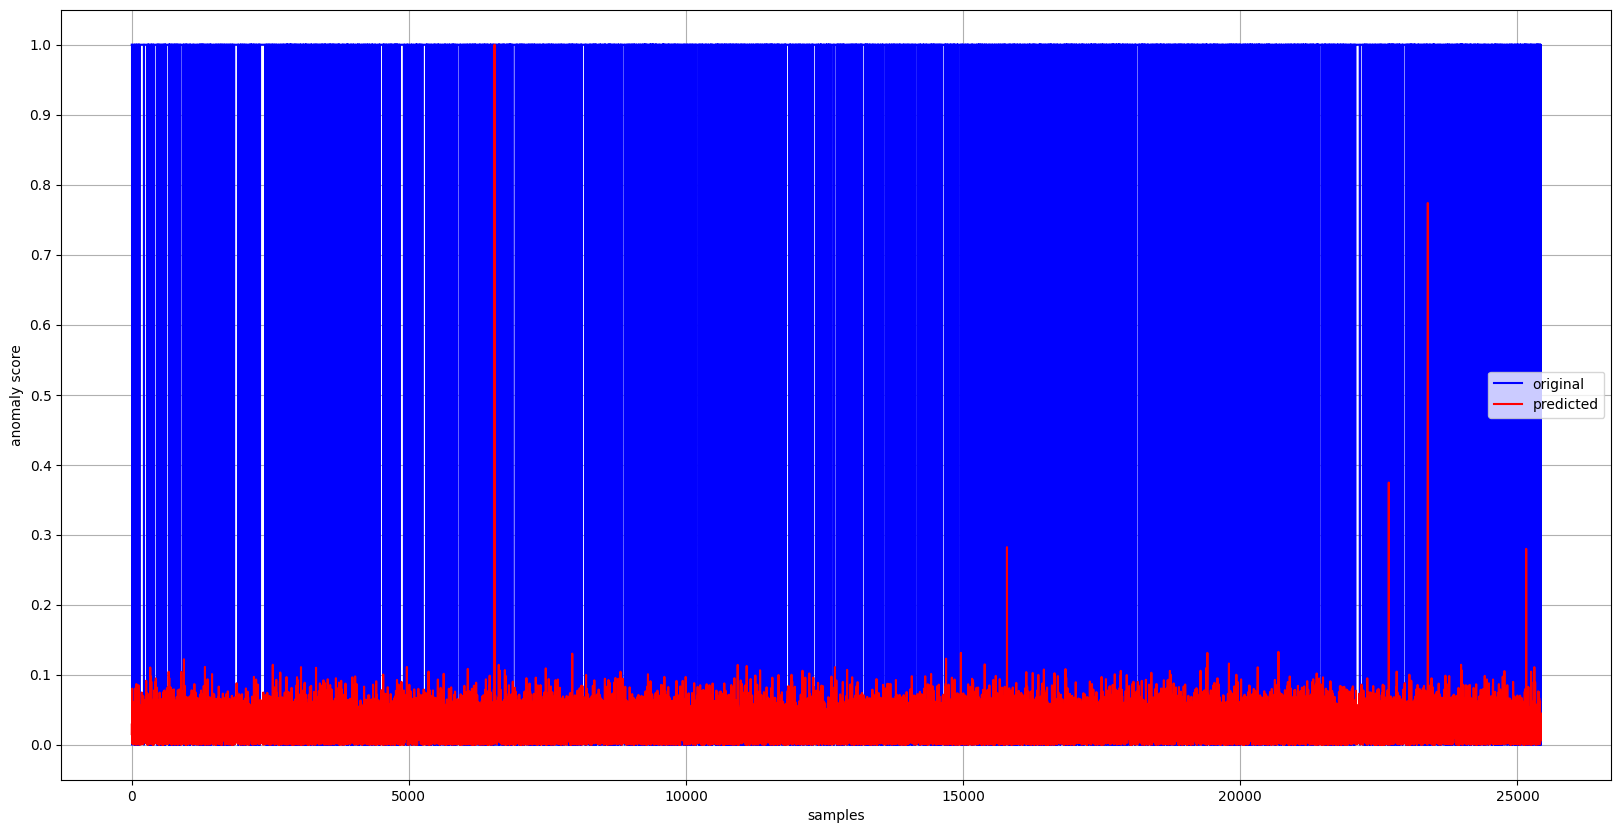

In [42]:
plt.figure(figsize=(20, 10))
plt.plot(test_labels, c='blue', label='original')
plt.plot(anomaly_scores, c='red', label='predicted')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.grid()
plt.legend()
plt.show()

Measuring the effectiveness of classifier

In [43]:
fpr, tpr, thresholds = roc_curve(test_labels, anomaly_scores)

In [44]:
auc = roc_auc_score(test_labels, anomaly_scores)
print('Area under ROC curve: {}'.format(auc))

Area under ROC curve: 0.7288930725277765


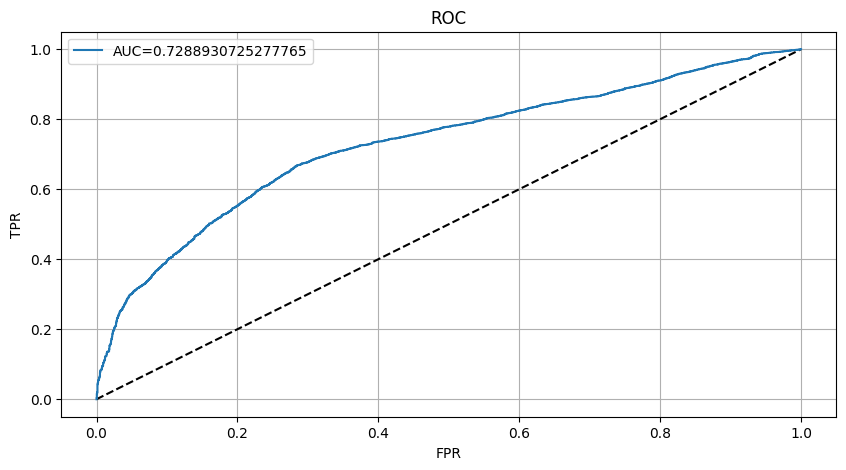

In [45]:
plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], color = 'black', linestyle='--')
plt.plot(fpr, tpr, label='AUC={}'.format(auc))
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC')
plt.show()


Identifying anomalies in test set

In [46]:
anomaly_combinations = [(anomaly_scores>i).astype(np.int32) for i in thresholds]
f1_scores = [f1_score(test_labels, i) for i in anomaly_combinations]

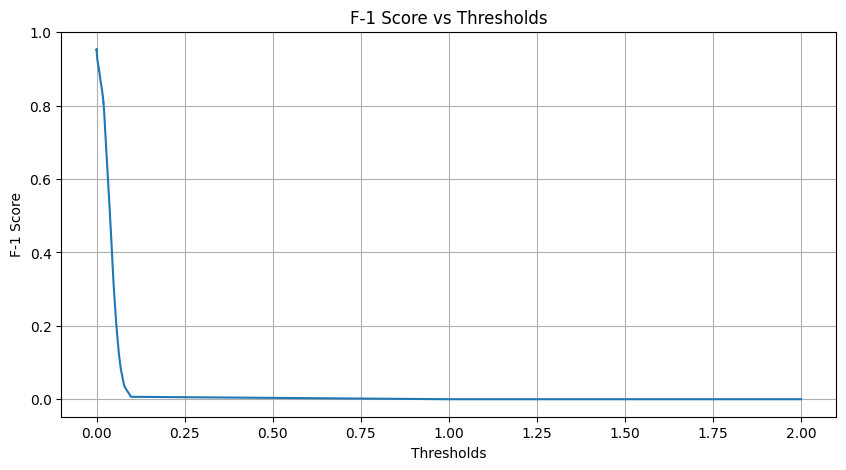

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores)
plt.grid()
plt.xlabel('Thresholds')
plt.ylabel('F-1 Score')
plt.title('F-1 Score vs Thresholds')
plt.show()

In [48]:
max_f1_score = np.max(f1_scores)
best_threshold = thresholds[f1_scores.index(max_f1_score)]
print('best threshold = {}'.format(best_threshold))

best threshold = 1.5811428966117091e-06


In [49]:
anomaly_indicator = (anomaly_scores>best_threshold).astype(np.int32)

In [50]:
confusion_matrix(test_labels, anomaly_indicator)

array([[    1,  2238],
       [    1, 23184]])

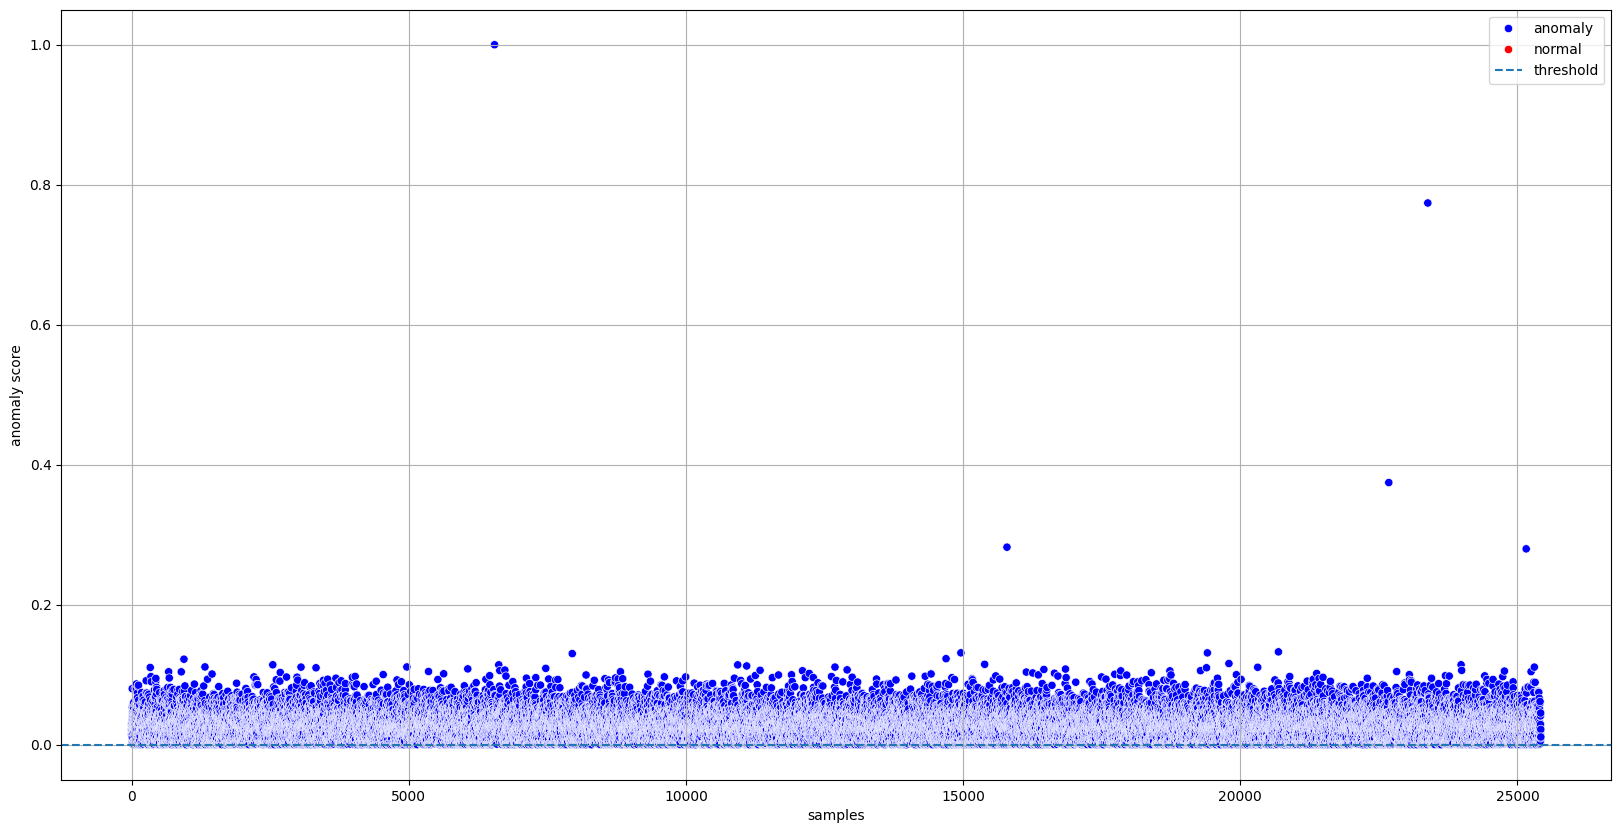

In [51]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=np.arange(0, len(anomaly_scores)), y= anomaly_scores, hue=['normal' if i==0 else 'anomaly' for i in anomaly_indicator],
                palette=['blue', 'red'], legend='full')
plt.axhline(y = best_threshold, linestyle='--', label='threshold')
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.legend()
plt.grid()
plt.show()

In [52]:
precision = precision_score(test_labels, anomaly_indicator)
recall = recall_score(test_labels, anomaly_indicator)
f1_sc = f1_score(test_labels, anomaly_indicator)
accuracy_sc = accuracy_score(test_labels, anomaly_indicator)

In [53]:
print('Model has the following classification metrics:\n precision = {}\n recall = {}\n f1_score = {}\n accuracy_score = {}'
      .format(precision, recall, f1_sc, accuracy_sc))

Model has the following classification metrics:
 precision = 0.9119660136889308
 recall = 0.9999568686650852
 f1_score = 0.953936675787438
 accuracy_score = 0.9119336060415355
